In [1]:
import time
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

# Binospec Dev Section

In [ ]:
bino = WFSFactory(wfs="binospec")

In [ ]:
bino.modes['binospec']['reference']['figure'].show()

In [ ]:
bino.modes['binospec']['reference']['xspacing'], bino.modes['binospec']['reference']['yspacing']

In [ ]:
bino.modes['binospec']['reference']['apertures']

# MMIRS Dev Section

In [ ]:
mmirs = WFSFactory(wfs="mmirs")

In [ ]:
mmirs.modes['mmirs1']['reference']['figure'].show()

In [ ]:
mmirs.modes['mmirs1']['reference']['xspacing'], mmirs.modes['mmirs1']['reference']['yspacing']

In [ ]:
print(mmirs.modes['mmirs1']['reference']['fwhm'])

spot = mmirs.modes['mmirs1']['reference']['spot']
model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2) + Polynomial2D(degree=0)
#model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
fitter = LevMarLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
fig, ax = plt.subplots()
ax.imshow(mmirs.modes['mmirs1']['reference']['spot'] - fit(x, y))
fig.show()

In [ ]:
plt.close('all')
mmirs_file = "/Users/tim/MMT/wfsdat/20170416/rawdata/mmirs_wfs_%04d.fits" % 213
results = mmirs.measure_slopes(mmirs_file, plot=True)
results['figures']['slopes'].show()

In [ ]:
results['apertures'].positions

In [ ]:
results['figures']['pupil_center'].show()

In [ ]:
zresults = mmirs.fit_wavefront(results, plot=True)
zvec = zresults['zernike']
print(zresults['residual_rms'])
#zvec.normalize()
print(zvec)
zresults['resid_plot'].show()

In [ ]:
zplot = zvec.copy()
zplot.ignore('Z02')
zplot.ignore('Z03')
mfig = zplot.plot_map()
mfig.show()
zplot.peak2valley

In [ ]:
zvec.units = u.nm
f = zvec.bar_chart(residual=zresults['residual_rms'])
f.set_size_inches(9, 5)

f.show()

In [ ]:
plt.close(f)

In [ ]:
torig = mmirs.telescope.bending_forces(zvec)
torig.show_in_notebook()

In [ ]:
force_fig = mmirs.telescope.plot_forces(torig)
force_fig.show()

In [ ]:
t, m1foc = mmirs.correct_primary(zv=zvec)
print(m1foc)
t.show_in_notebook()

In [ ]:
new_force_fig = mmirs.telescope.plot_forces(t)
new_force_fig.show()

In [ ]:
zpsf = ZernikeVector()
psf, psf_fig = mmirs.telescope.psf(zpsf, plot=True)
psf_fig.set_size_inches(4.0, 4.0)
psf_fig.show()

# F/9 Dev Section

In [2]:
plt.close('all')

f9wfs = WFSFactory(wfs="newf9")

In [3]:
f9wfs.modes['blue']['reference']['xspacing'], f9wfs.modes['blue']['reference']['yspacing']

(33.783783783783782, 19.54954954954955)

<IPython.core.display.Javascript object>


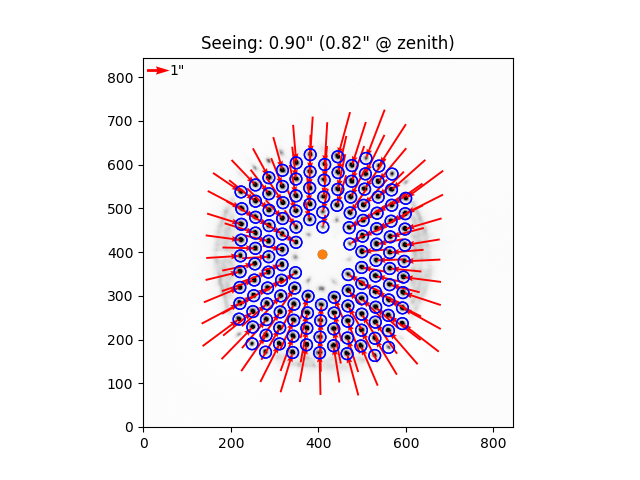

In [4]:
f9_file = "/Users/tim/MMT/wfsdat/datadir/f9wfs_20171007-000151.fits"
refaps = f9wfs.modes['blue']['reference']['apertures']
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
#plt.scatter(refaps['xcentroid']+results['xcen'], refaps['ycentroid']+results['ycen'])
results['figures']['slopes'].show()
# 265 258
# ref 240 259.5

174.49623756896887 nm
Fringe Coefficients
 Z02:      -114 nm 	 X Tilt (1, 1)
 Z03: -1.09e+03 nm 	 Y Tilt (1, -1)
 Z04:       305 nm 	 Defocus (2, 0)
 Z05:      98.8 nm 	 Primary Astig at 45° (2, -2)
 Z06:      -767 nm 	 Primary Astig at 0° (2, 2)
 Z07:      95.6 nm 	 Primary Y Coma (3, -1)
 Z08:      -195 nm 	 Primary X Coma (3, 1)
 Z09:       -23 nm 	 Y Trefoil (3, -3)
 Z10:      -217 nm 	 X Trefoil (3, 3)
 Z11:      -250 nm 	 Primary Spherical (4, 0)
 Z12:     -63.4 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:     -92.7 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:      -206 nm 	 X Tetrafoil (4, 4)
 Z15:      55.8 nm 	 Y Tetrafoil (4, -4)
 Z16:      -168 nm 	 Secondary X Coma (5, 1)
 Z17:       -36 nm 	 Secondary Y Coma (5, -1)
 Z18:      -153 nm 	 Secondary X Trefoil (5, 3)
 Z19:       165 nm 	 Secondary Y Trefoil (5, -3)
 Z20:       112 nm 	 X Pentafoil (5, 5)
 Z21:       201 nm 	 Y Pentafoil (5, -5)
 Z22:      -205 nm 	 Secondary Spherical (6, 0)
 Z23:      74.5 nm 	 Tertiary A

<IPython.core.display.Javascript object>


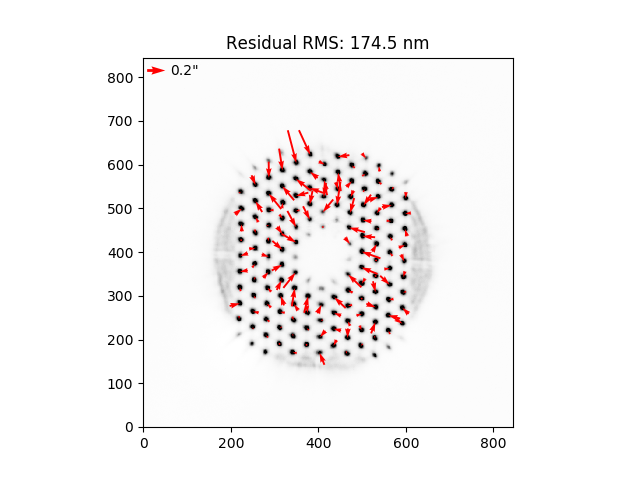

In [5]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['residual_rms'])
print(zresults['zernike'])
zresults['resid_plot'].show()

In [ ]:
fig, ax = plt.subplots()
fit = results['grid_fit']
refx = refaps['xcentroid'] * (fit['scale'] + refaps['xcentroid'] * fit['xcoma']) + results['xcen']
refy = refaps['ycentroid'] * (fit['scale'] + refaps['ycentroid'] * fit['ycoma']) + results['ycen']
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
spacing = 0.5*(results['xspacing'] + results['yspacing'])
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 845)
ax.set_ylim(0, 845)
fig.show()

In [ ]:
fit

In [ ]:
spots = {'xcentroid': x, 'ycentroid': y}
from scipy import optimize

def match_apertures(refx, refy, spotx, spoty):
    tot_dist = 0.0
    refs = np.array([refx, refy])
    spots = np.array([spotx, spoty])
    match = np.empty(len(refx))
    max_r = spacing / 2.
    for i in np.arange(len(refx)):
        dists = np.sqrt( (spots[0]-refs[0][i])**2 + (spots[1]-refs[1][i])**2 )
        tot_dist += np.min(dists)
    return tot_dist

def fit_apertures(pars, ref, spots):
    xc = pars[0]
    yc = pars[1]
    xscale = pars[2]
    yscale = pars[3]
    xcoma = pars[4]
    ycoma = pars[5]
    refx = ref['xcentroid'] * (xscale + ref['xcentroid'] * xcoma) + xc
    refy = ref['ycentroid'] * (yscale + ref['ycentroid'] * ycoma) + yc
    spotx = spots['xcentroid']
    spoty = spots['ycentroid']
    dist = match_apertures(refx, refy, spotx, spoty)
    return dist

In [ ]:
#%%timeit
args = (refaps, spots)
pars = (results['xcen'], results['ycen'], 1.0, 1.0, 0.0, 0.0)
bounds = (
    (results['xcen']-50, results['xcen']+50), 
    (results['ycen']-50, results['ycen']+50),
    (0.8, 1.2),
    (0.8, 1.2),
    (-0.1, 0.1),
    (-0.1, 0.1)
)
res = optimize.minimize(fit_apertures, pars, args=args, bounds=bounds)
res

In [ ]:
fig, ax = plt.subplots()
refx, refy = refaps['xcentroid'], refaps['ycentroid']
refx = refx * (res['x'][2] + refx*res['x'][4]) + res['x'][0]
refy = refy * (res['x'][3] + refy*res['x'][5]) + res['x'][1]
x, y = results['apertures'].positions.transpose()[0], results['apertures'].positions.transpose()[1]
ax.scatter(refx, refy)
ax.set_aspect('equal')
ax.scatter(x, y)
ax.set_xlim(0, 845)
ax.set_ylim(0, 845)
fig.show()

In [ ]:
print(f9wfs.modes['blue']['reference']['xcen'], f9wfs.modes['blue']['reference']['ycen'])
print(f9wfs.modes['blue']['reference']['xspacing'], f9wfs.modes['blue']['reference']['yspacing'])
f9wfs.modes['blue']['reference'].keys()

In [ ]:
zv = zresults['zernike']
print(zv.rms)
zv.ignore('Z02')
zv.ignore('Z03')
f = zv.plot_map()
f.show()

In [ ]:
bc = zv.bar_chart(residual=zresults['residual_rms'])
bc.show()

In [ ]:
psf, psf_fig = f9wfs.telescope.psf(zv, fov=1.0)
psf_fig.show()

In [ ]:
plt.close('all')

# F/5 Dev Section

In [ ]:
plt.close('all')
f5wfs = WFSFactory(wfs="f5")

In [ ]:
#%%prun
f5_file = "/Users/tim/MMT/wfsdat/20170605/manual_wfs_0005.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
results['figures']['slopes'].show()

In [ ]:
#%%prun
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
print(zv.rms)
zresults['resid_plot'].show()

In [ ]:
zf = zv.bar_chart(residual=zresults['residual_rms'], total=True, max_c=500*u.nm)
zf.show()
zresults['residual_rms']

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
mf = zv.plot_map()
mf.axes[0].set_title("boo")
mf.show()

In [ ]:
t, m1foc = f5wfs.telescope.calculate_primary_corrections(zresults['zernike'])

In [ ]:
fplot = f5wfs.telescope.plot_forces(t, m1focus=m1foc)
fplot.show()

In [ ]:
t.show_in_notebook()

# Scratch space

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [ ]:
t = f9wfs.telescope
m = t.zern_map

In [ ]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")
z1 = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.av.zrn")

In [ ]:
z1 - z

In [ ]:
Z = ZernikeVector(coeffs=z, zmap=m)

In [ ]:
Z

In [ ]:
from astropy.table import Table
from astropy.io import ascii

In [ ]:
t = ascii.read("/Users/tim/MMT/mmtwfs/mmtwfs/data/mmirszernfield.tab")

In [ ]:
t

In [ ]:
np.interp(0.12, t['field_r'], t['Z01'])

In [ ]:
range(4, 11)

In [ ]:
for i in range(4, 12):
    print("Z%02d" % i)

In [ ]:
np.max(1, 2)

In [ ]:
6.75 + 20.30 + 242.15 + 430.51

In [ ]:
13296 - (973.15/.575) - 1025.8

In [ ]:
23*6 + 12*6

In [ ]:
58.69*12

In [ ]:
210+16+69.5+704.28

In [ ]:
2225.37 - (977.15 + 999.78 + 699.71)

In [ ]:
103212.81+341.47-451.27+9632.5

In [ ]:
7324.5+3951.34

In [ ]:
112735.51 - (11275.84 + 7245.8 + 56) - 12150

In [ ]:
4050*3

In [ ]:
3000*.05

In [ ]:
28910/98610

In [ ]:
ai = [247.68, 252.69, 257.79, 261.79, 266.88, 696.98, 280.11, 261.96, 261.96, 261.92, 261.96]
pep = [146.43, 147.28, 145.18, 142.83, 140.7, 138.47, 136.4, 134.18, 132.18, 129.89, 128.12, 126.22]

In [ ]:
0.2* (28910/98610 * (np.sum(ai) + np.sum(pep)))

In [ ]:
len(pep)

In [ ]:
12049 - (290.81 + 850)

In [ ]:
18577.64-7324.5

In [ ]:
110940.01-11253.14 - 9600

In [ ]:
0.032 * 90086.87 + 4226.63

In [ ]:
x = 1920 * 5.86e-3 * u.mm

y = 1200 * 5.86e-3 * u.mm

In [ ]:
np.sqrt(x**2 + y**2)

In [ ]:
np.max((1, 2))

In [ ]:
mmirs.pup_size

In [ ]:
mmirs.modes['mmirs2']['reference']['sigma']

In [ ]:
sigma = results['fwhm'] * stats.funcs.gaussian_fwhm_to_sigma

wave = 650 * u.nm
wave = wave.to(u.m).value  # r_0 equation expects meters so convert
# calculate the physical size of each aperture.
ref = mmirs.modes['mmirs2']['reference']
apsize_pix = np.max((ref['xspacing'], ref['yspacing']))
d = mmirs.telescope.diameter * apsize_pix / mmirs.pup_size
d = d.to(u.m).value  # r_0 equation expects meters so convert

# we need to deconvolve the instrumental spot width from the measured one
ref_sigma = ref['sigma']
if sigma > ref_sigma:
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
else:
    corr_sigma = 0.0
corr_sigma *= mmirs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert
# this equation relates the motion within a single aperture to the characteristic scale size of the
# turbulence, r_0.
r_0 = ( 0.179 * (wave**2) * (d**(-1./3.))/corr_sigma**2 )**0.6
print(r_0)
# this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
raw_seeing = u.rad * 0.98 * wave / r_0
raw_seeing = raw_seeing.to(u.arcsec)


In [ ]:
"{0.value:0.2f}{0.unit:unicode}".format(raw_seeing)

In [ ]:
np.sqrt(sigma**2 - ref_sigma**2)

In [ ]:
def_mask = ['Z02', 'Z03', 'Z04']
mask = ['Z04', 'Z10']
def_mask.extend(mask)
mask = list(set(def_mask))
mask

In [ ]:
f = ZernikeVector()

In [ ]:
mmirs.telescope.bending_forces(zv=f)

In [ ]:
z = ZernikeVector(Z07=500*u.nm)
z.plot_map()
plt.show()

In [ ]:
-z['Z08']

In [ ]:
xc, yc = 245, 270
xcen, ycen = 255, 255
dx = xc - xcen
dy = yc - ycen
dr, phi = cart2pol([dx, dy])

In [ ]:
derot_phi = phi - u.Quantity(225*u.deg, u.rad).value
pol2cart([dr, derot_phi])

In [ ]:
u.Quantity(225*u.deg, u.rad).value

In [ ]:
dx, dy

In [ ]:
t = mmirs.telescope
zv = ZernikeVector(Z05=1000, Z11=250)
force, focus = t.correct_primary(zv)
f1 = focus.copy()
uforce, ufocus = t.undo_last()
print(ufocus)
print(f1)
assert(ufocus == -1 * f1)

In [ ]:
focus.copy()

In [ ]:
np.allclose(np.zeros(2), 0.0)

In [ ]:
s = "offset_inc wfs z 200.3"
assert("200.3" in s)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.imshow(results['data'], cmap=cm.Greys)
fig.savefig("test.png")

In [ ]:
a = fig.axes[0]

In [ ]:
fig.show()

In [ ]:
"{0:0.0f}".format((550 * u.nm))

In [ ]:
x, y, r, p, ph = zvec.phase_map(n=100)
i = np.argsort(x)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [ ]:
data = [go.Heatmap(z=np.array(ph[i]), x=x[i], y=y[i], colorscale='RdBu')]
layout = go.Layout(title="test")
fig = go.Figure(data=data, layout=layout)
plot(fig, filename="blah")

In [ ]:
np.min(ph)

In [ ]:
0.119 * 5.4*3/20

In [ ]:
if 'HOME' in os.environ:
    print('y')

In [ ]:
np.zeros((512, 512)).shape

In [ ]:
zv = ZernikeVector()

In [ ]:
zv.plot_map()

In [ ]:
t = MMT()
zv = ZernikeVector(Z05=1000, Z11=250)
force, focus = t.calculate_primary_corrections(zv)

In [ ]:
lforce, lfocus = t.correct_primary(force, focus)

In [ ]:
uforce, ufocus = t.undo_last()

In [ ]:
focus, lfocus, ufocus

In [ ]:
newf9 = WFSFactory(wfs="newf9")

In [ ]:
newf9.modes['blue']['reference']

In [ ]:
x = newf9.modes['blue']['reference']['apertures']['xcentroid'] + newf9.modes['blue']['reference']['xcen']

In [ ]:
y = newf9.modes['blue']['reference']['apertures']['ycentroid'] + newf9.modes['blue']['reference']['ycen']

In [ ]:
arr = np.array((x.data, y.data)).transpose()

In [ ]:
np.savetxt("blah.txt", arr, fmt="%.3f")

In [ ]:
np.savetxt?

In [ ]:
x, y = 405, 445
xnew, ynew = 438, 469
xref, yref = 433, 431
pixsize = 0.09639

rot = u.Quantity(-225 * u.deg, u.rad).value

dx = x - xref
dy = y - yref

dr, phi = cart2pol([dx, dy])

derot_phi = phi - rot

az, el = pol2cart([dr, derot_phi])
print(az, el)

In [ ]:
x, y = 405, 445
xnew, ynew = 438, 469
xref, yref = 433, 431
pixsize = 0.09639

rot = u.Quantity(-225 * u.deg, u.rad).value

dx = 1 * (x - xref)
dy = 1 * (y - yref)

dr, phi = cart2pol([dx, dy])

derot_phi = phi - rot

az, el = pol2cart([dr, derot_phi])
print(az, el)

In [ ]:
azcorr = 3.0 / pixsize
elcorr = 0.9 / pixsize
drc, phic = cart2pol([azcorr, elcorr])
derot_phic = phic + rot
az_pix, el_pix = pol2cart([drc, derot_phic])
print(az_pix, el_pix)

In [ ]:
a = np.arange(5)

In [ ]:
np.delete(a, 2)